In [64]:
# Загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report


In [65]:
# загружаем декодер порядковый
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical

# IO utils


In [66]:
# пишем функцию, для прочитывания датасета.
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [67]:
# выпишем все наши тесты в отдельные переменные.


palm_file_31='2024-12-13_19-48-48.emg8'
palm_file_32='2024-12-13_19-53-58.emg8'
palm_file_33='2024-12-13_20-00-16.emg8'

palm_file_34='2024-12-15_14-56-56.emg8'
palm_file_35='2024-12-15_15-02-08.emg8'
palm_file_36='2024-12-15_15-06-56.emg8'


In [68]:
df=pd.read_csv(palm_file_32, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')


In [69]:
# Записываем в переменную  файл для примера
palm_file = palm_file_32
# Записываем в переменную датасет
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=20,
                              n_acc_channels=7, 
                              n_gyr_channels=7, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(5774, 43)


,0,1,2,3,4,5,6,7,8,9,...,GYR6,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,380698.0,40.0,13907471.0,11153386.0,7295219.0,10596543.0,9293714.0,8280127.0,9344695.0,13301749.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.00
1,380738.0,40.0,13896318.0,11151604.0,7297517.0,10598951.0,9299420.0,8279141.0,9347969.0,13301417.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.04
2,380778.0,40.0,13890855.0,11142356.0,7299671.0,10599734.0,9295018.0,8276756.0,9346447.0,13304033.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.08
3,380818.0,40.0,13883430.0,11135593.0,7302888.0,10601965.0,9292689.0,8276616.0,9350914.0,13307251.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.12
4,380858.0,40.0,13880037.0,11129999.0,7302866.0,10603165.0,9295420.0,8276619.0,9345903.0,13306060.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.16


In [70]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', 'ACC0', 'ACC1', 'ACC2',
       'ACC3', 'ACC4', 'ACC5', 'ACC6', 'GYR0', 'GYR1', 'GYR2', 'GYR3', 'GYR4',
       'GYR5', 'GYR6', 'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5',
       'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [71]:
# Записываем в переменные разбитие наших признаков. И выводим их на экран.
OMG_CH = [str(i) for i in range(20)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2','ACC3','ACC4','ACC5','ACC6']
GYR_CH = ['GYR0', 'GYR1', 'GYR2','GYR3','GYR4','GYR5','GYR6']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
ACC_CH: ['ACC0', 'ACC1', 'ACC2', 'ACC3', 'ACC4', 'ACC5', 'ACC6']
GYR_CH: ['GYR0', 'GYR1', 'GYR2', 'GYR3', 'GYR4', 'GYR5', 'GYR6']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


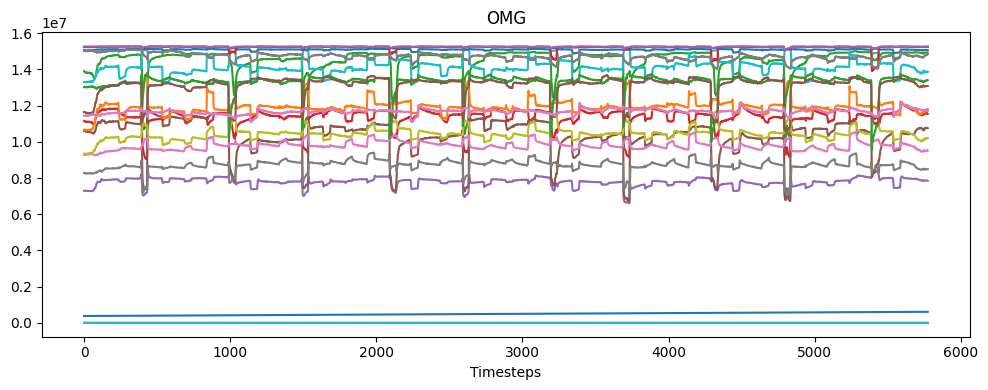

In [72]:
# Выводим на экран график изменения наших датчиков на протяжении всего времени.
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [73]:
gestures

,0,1,2,3,4,5,6,7,8,9,...,GYR6,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,380698.0,40.0,13907471.0,11153386.0,7295219.0,10596543.0,9293714.0,8280127.0,9344695.0,13301749.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.00
1,380738.0,40.0,13896318.0,11151604.0,7297517.0,10598951.0,9299420.0,8279141.0,9347969.0,13301417.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.04
2,380778.0,40.0,13890855.0,11142356.0,7299671.0,10599734.0,9295018.0,8276756.0,9346447.0,13304033.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.08
3,380818.0,40.0,13883430.0,11135593.0,7302888.0,10601965.0,9292689.0,8276616.0,9350914.0,13307251.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.12
4,380858.0,40.0,13880037.0,11129999.0,7302866.0,10603165.0,9295420.0,8276619.0,9345903.0,13306060.0,...,0.12,0.12,0.12,0.12,0.0,0.0,0,Baseline,-1,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5769,611458.0,40.0,14928477.0,11554381.0,7857294.0,10756670.0,9505484.0,8486004.0,10197759.0,13862547.0,...,0.12,0.12,0.12,0.12,0.0,0.0,116,Finish,-1,230.76
5770,611498.0,40.0,14927144.0,11547512.0,7851089.0,10751334.0,9496126.0,8482454.0,10189301.0,13858161.0,...,0.12,0.12,0.12,0.12,0.0,0.0,116,Finish,-1,230.80
5771,611538.0,40.0,14926105.0,11543517.0,7849741.0,10750274.0,9504373.0,8484689.0,10198065.0,13861895.0,...,0.12,0.12,0.12,0.12,0.0,0.0,116,Finish,-1,230.84
5772,611578.0,40.0,14925719.0,11538027.0,7844675.0,10749024.0,9513932.0,8487467.0,10204178.0,13872638.0,...,0.12,0.12,0.12,0.12,0.0,0.0,116,Finish,-1,230.89


### Protocol

In [74]:
# Выведем на экран значения столбце  'SYNC', синхронизация данных с протоколом, по порядку.
gestures['SYNC'].value_counts()

SYNC
 0    3750
-1     274
 6     250
 1     250
 2     250
 7     250
 8     250
 3     250
 4     250
Name: count, dtype: int64

In [75]:
# Уникальные жесты
gestures['SYNC'].unique()

array([-1,  0,  6,  1,  2,  7,  8,  3,  4])

In [76]:
# Так как жесты -1 и 0 имеют одиннаковую природу (старт-финиш-нейтральный), то заменим жест -1 на 0 и получим в конце и в начале нейтральные жесты.
index_fn=gestures[(gestures['SYNC']==0)| (gestures['SYNC']==-1)].index
gestures.loc[index_fn,'SYNC']=0

In [77]:
index_0=gestures[gestures['SYNC']==0].index
gestures.loc[index_0,'BUTTON']='Neutral'

In [78]:
# Проверяем
gestures['SYNC'].value_counts()

SYNC
0    4024
6     250
1     250
2     250
7     250
8     250
3     250
4     250
Name: count, dtype: int64

In [148]:

GESTURES=['Neutral', 'ThumbFingers', 'Close', 'Open', 'Pinch','-' ,'Indication','Wrist_Flex', 'Wrist_Extend']

In [96]:
# Делим наши данные на тренировочную выборку и тестовую
from sklearn.model_selection import train_test_split
X=gestures[gestures.columns[2:18]]
y=gestures['SYNC']
X_train=X[:int(X.shape[0]*0.8)]
X_test=X[int(X.shape[0]*0.8):]
y_train=y[:int(gestures.shape[0]*0.8)]
y_test=y[int(gestures.shape[0]*0.8):]


Text(0.5, 1.0, 'OMG')

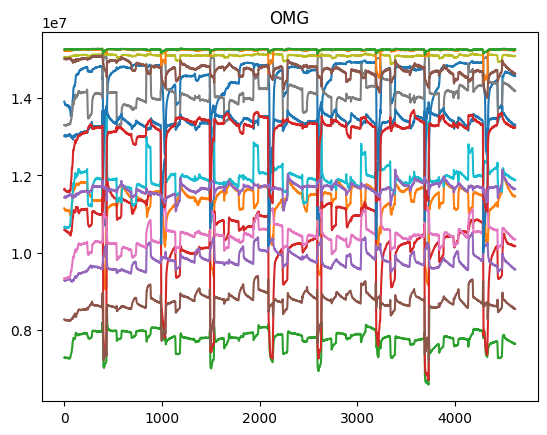

In [97]:
# График тренировочной выборки
import matplotlib.pyplot as plt
plt.plot(X_train.values)
plt.title('OMG')

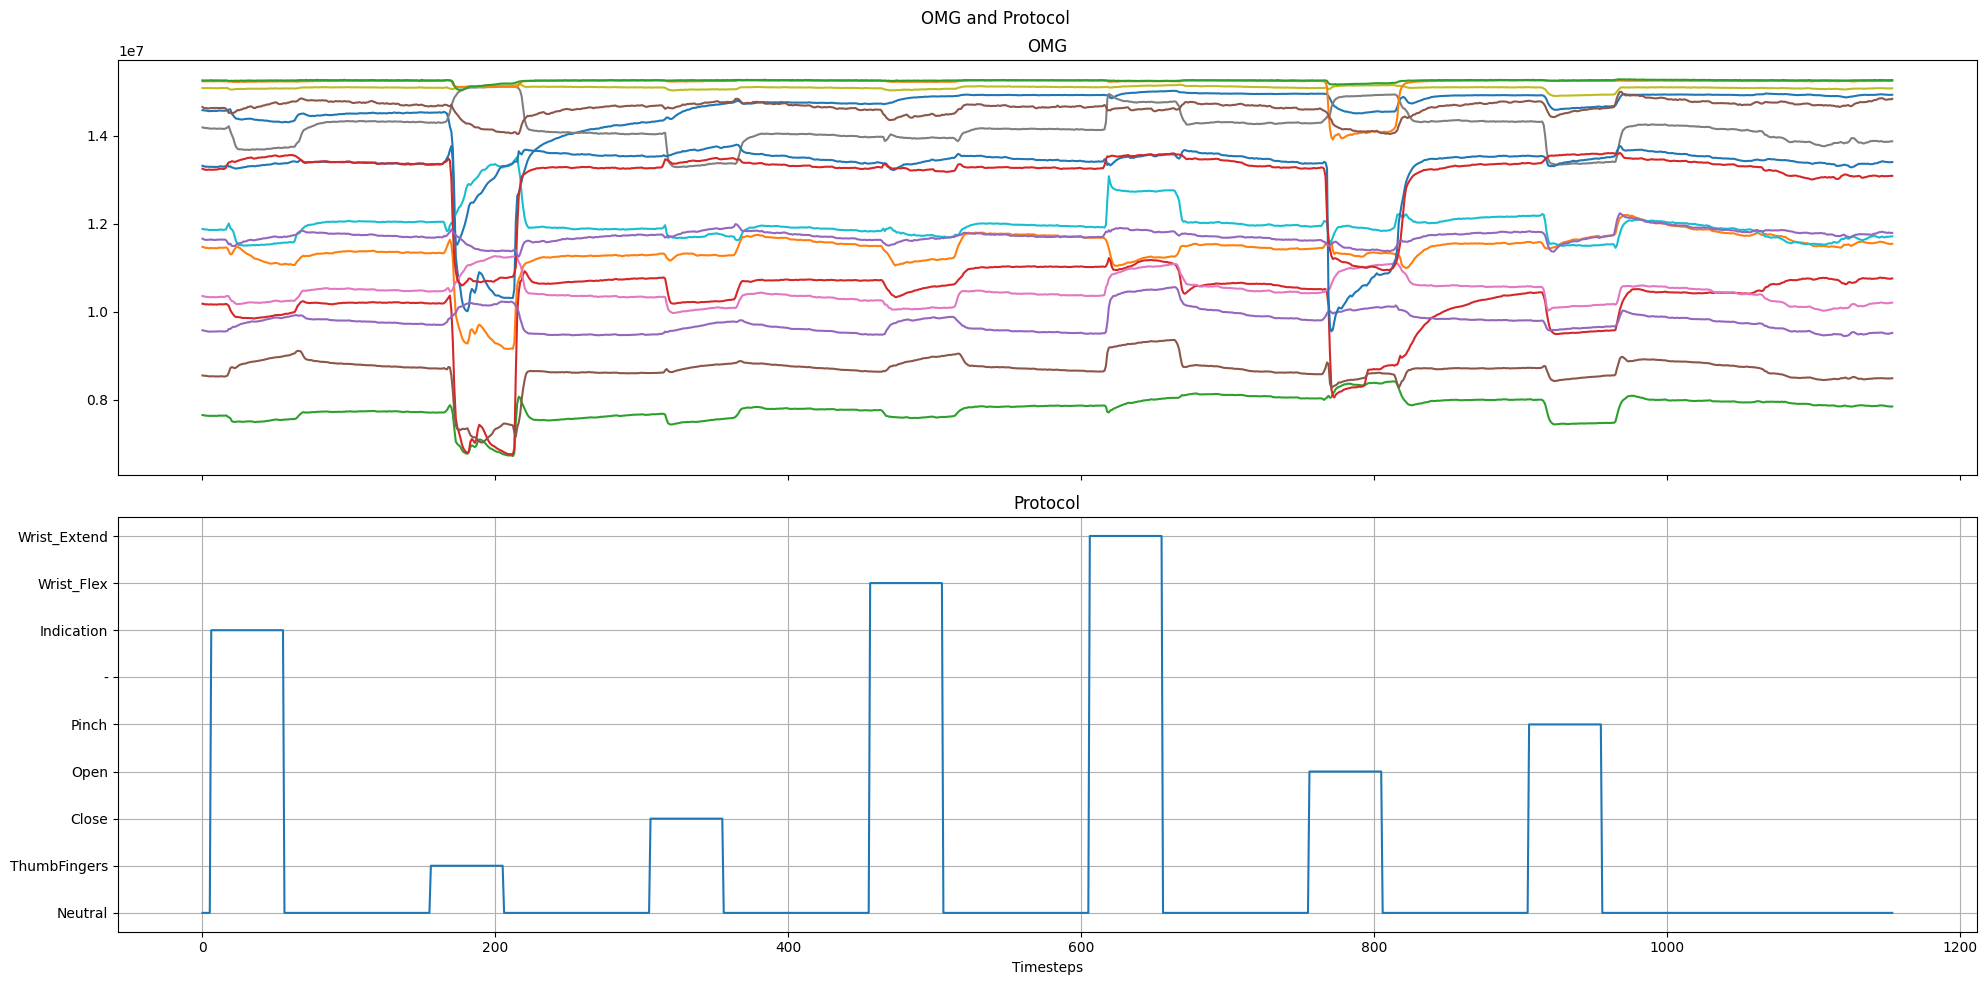

In [98]:
# На первом графике опять выводим работу наших датчиков в реальном времени на тестовых данных
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
plt.sca(axx[0])
plt.plot(X_test.values)
plt.title('OMG')
# На графике ниже мы выводим значения целевого признака.
plt.sca(axx[1])
plt.plot(np.array(y_test.values))
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)

plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

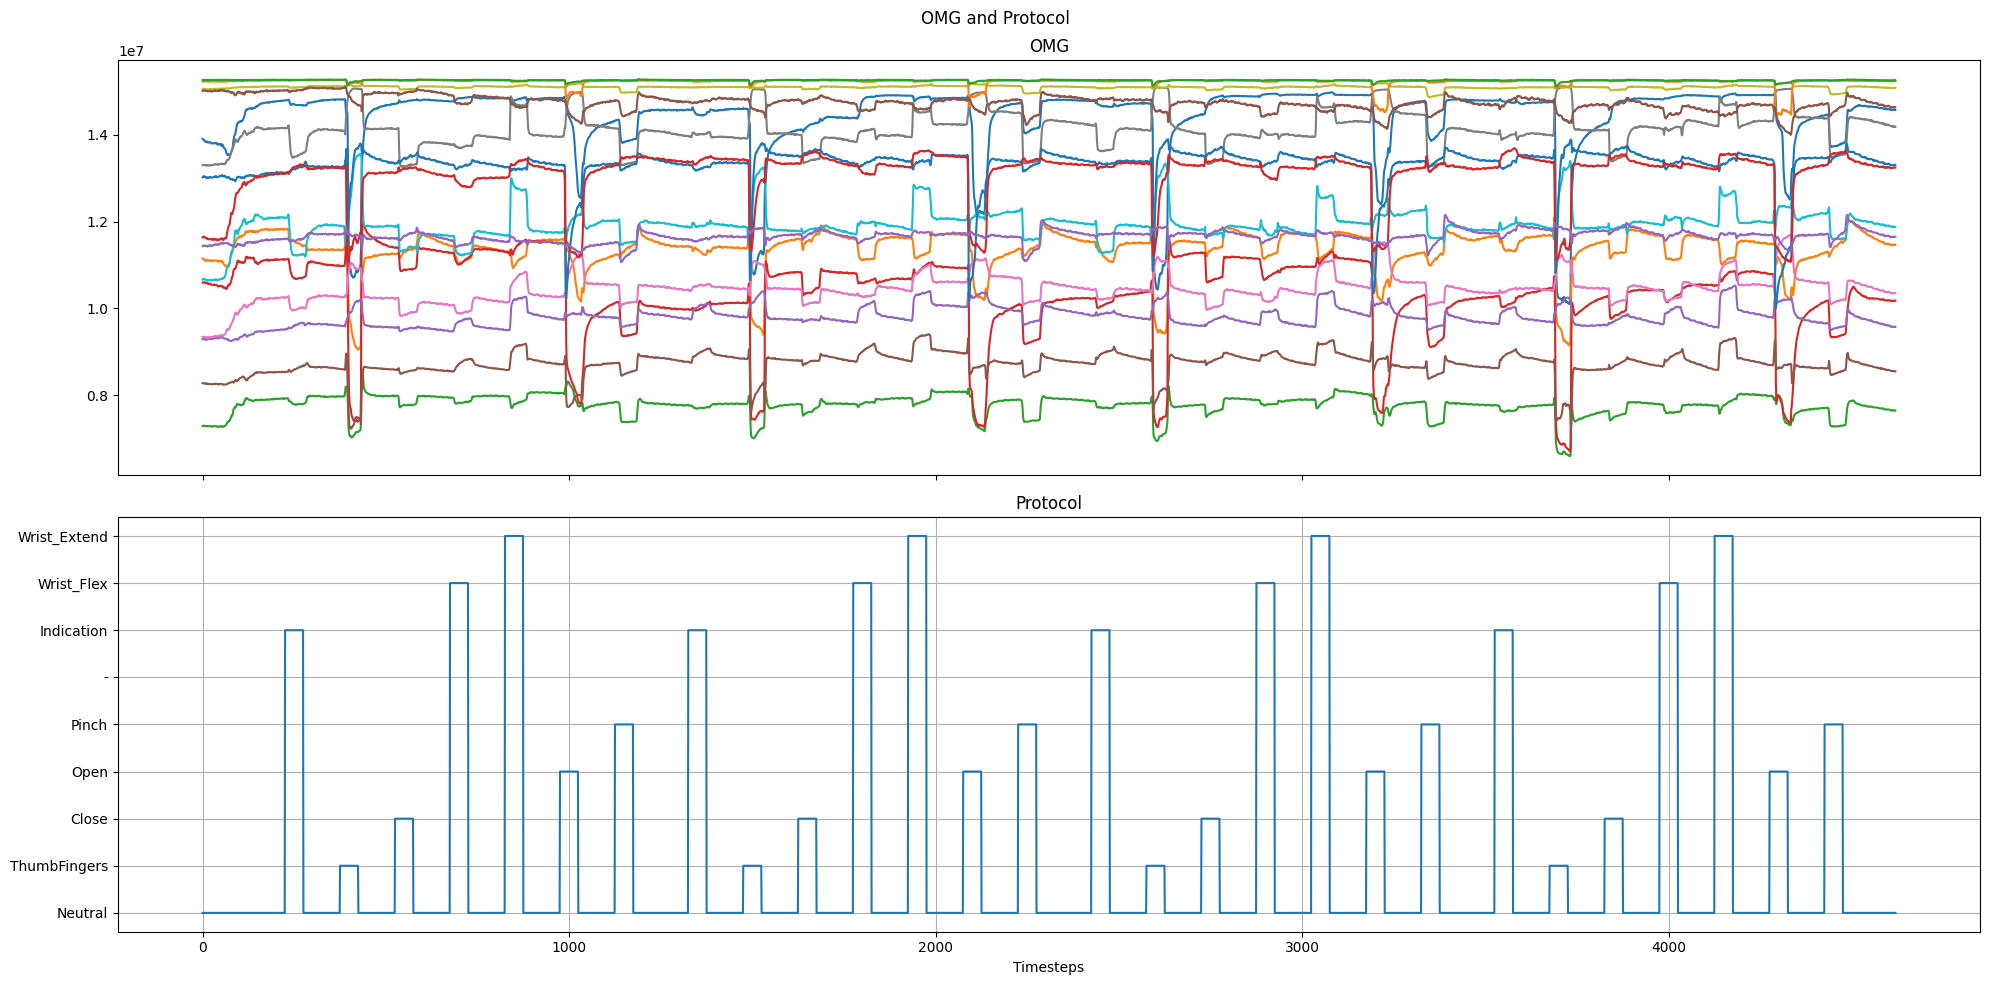

In [99]:
# На первом графике опять выводим работу наших датчиков в реальном времени на тренировочных данных
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
plt.sca(axx[0])
plt.plot(X_train.values)
plt.title('OMG')
# На графике ниже мы выводим значения целевого признака.
plt.sca(axx[1])
plt.plot(np.array(y_train.values))
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)

plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Modeling

In [ ]:
# возьмем модель Логистичекой регрессии и обучим на тренировочных данных
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(
    X=X_train,
    y=y_train
)

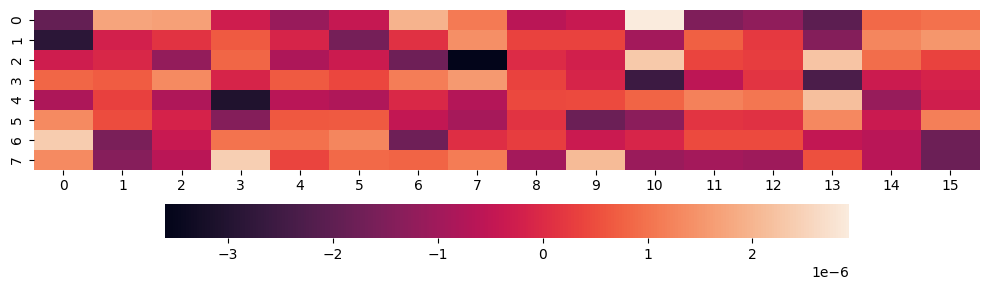

In [101]:
# Тепловая карта наших коэфициентов в разрезе каждого жеста
import seaborn as sns

plt.figure(figsize=(10, 3)) # 
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

In [102]:
# сделаем предсказание наших выборок
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

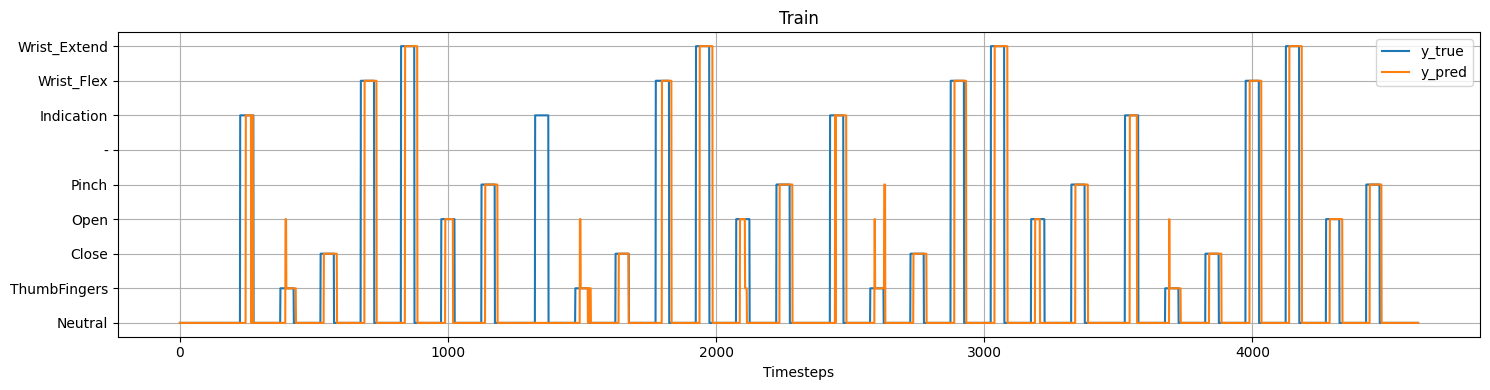

In [103]:
# график соответствия наших предсказаний на тренировочных данных с графиком правильных ответов так же на тренировочных данных
fig = plt.figure(figsize=(15, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')


plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

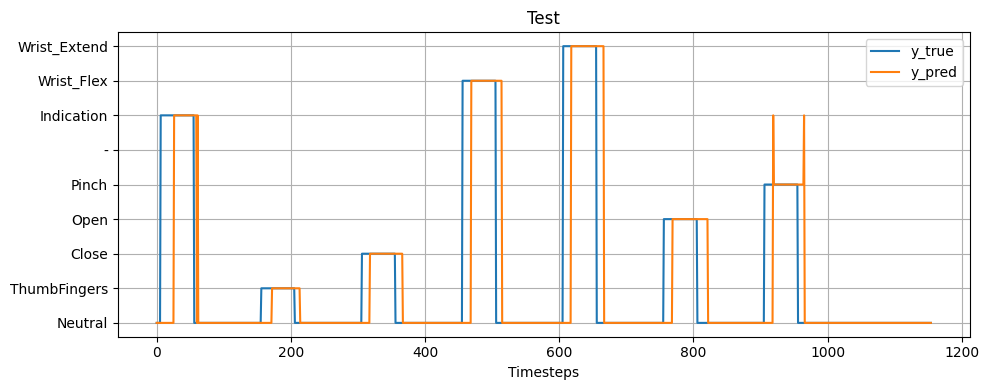

In [104]:
# Выведем график предсказаний и график правильных ответов на тестовых данных. Посмотрим визуально, как наша модель предсказывает класс
fig = plt.figure(figsize=(10, 4))


plt.plot(np.array(y_test),  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')


plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [105]:
# Выведем метрики по каждому классу в отдельности. На тренировочных данных
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3219
           1       0.79      0.61      0.69       200
           2       0.83      0.75      0.79       200
           3       0.84      0.51      0.63       200
           4       0.77      0.73      0.75       200
           6       0.88      0.41      0.56       200
           7       0.79      0.67      0.73       200
           8       0.76      0.72      0.74       200

    accuracy                           0.84      4619
   macro avg       0.82      0.67      0.72      4619
weighted avg       0.84      0.84      0.84      4619



In [106]:
# На тестовых
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       805
           1       0.81      0.68      0.74        50
           2       0.78      0.76      0.77        50
           3       0.70      0.74      0.72        50
           4       0.80      0.72      0.76        50
           6       0.81      0.60      0.69        50
           7       0.80      0.74      0.77        50
           8       0.78      0.76      0.77        50

    accuracy                           0.85      1155
   macro avg       0.79      0.74      0.76      1155
weighted avg       0.85      0.85      0.85      1155



# <center> Предобработка данных

--------------------------------------------------------------------------------------------

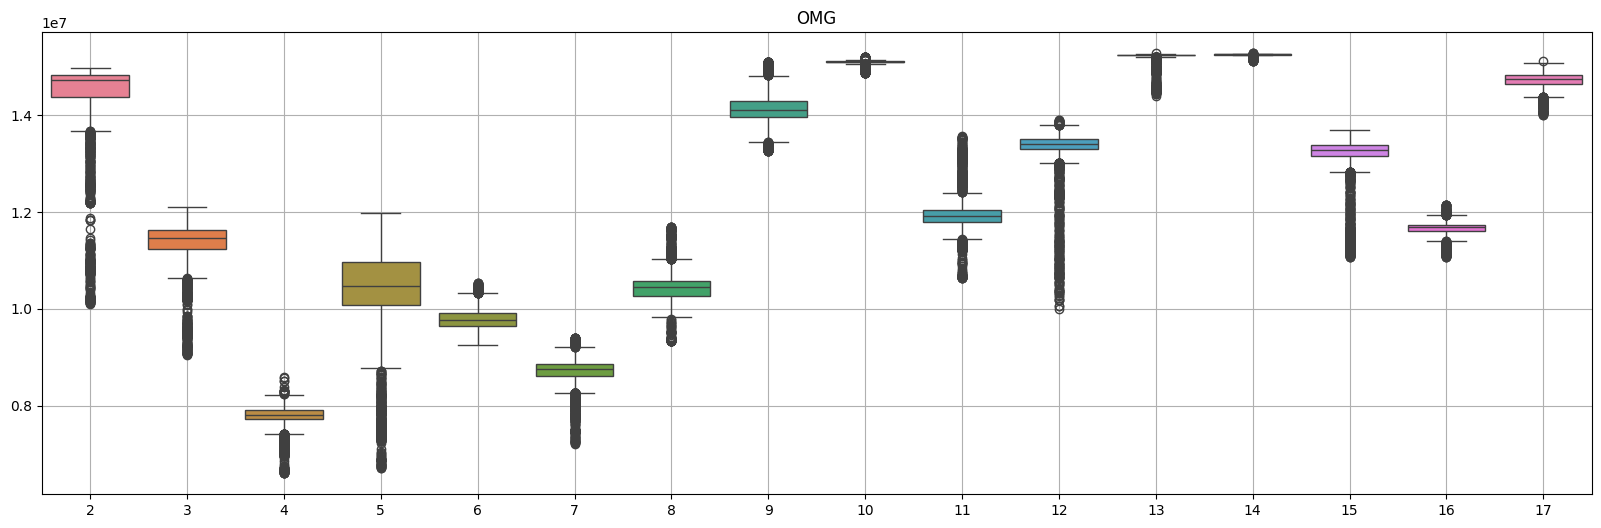

In [107]:
# График диапазонов работы наших датчиков.
graph=sns.boxplot(X_train)
graph.figure.set_size_inches(20,6)
plt.title('OMG')
plt.grid()

Видим, что наши датчики работают в разных числовых диапазонах, это нам говорит о том, что в дальнейшем необходимо будет сделать шкалирование.  

### <center> Смещение

Ранее замечено, что все предсказания были сделаны со смещением, т.е. определение класса в векторе правильных ответов было раньше чем определение его на датчиках. Это связано с тем, что реакция человека на ремонстрацию жеста не молненосная и сюда же добавляется задержка передач сигналов в манжета на компьютер через провода.

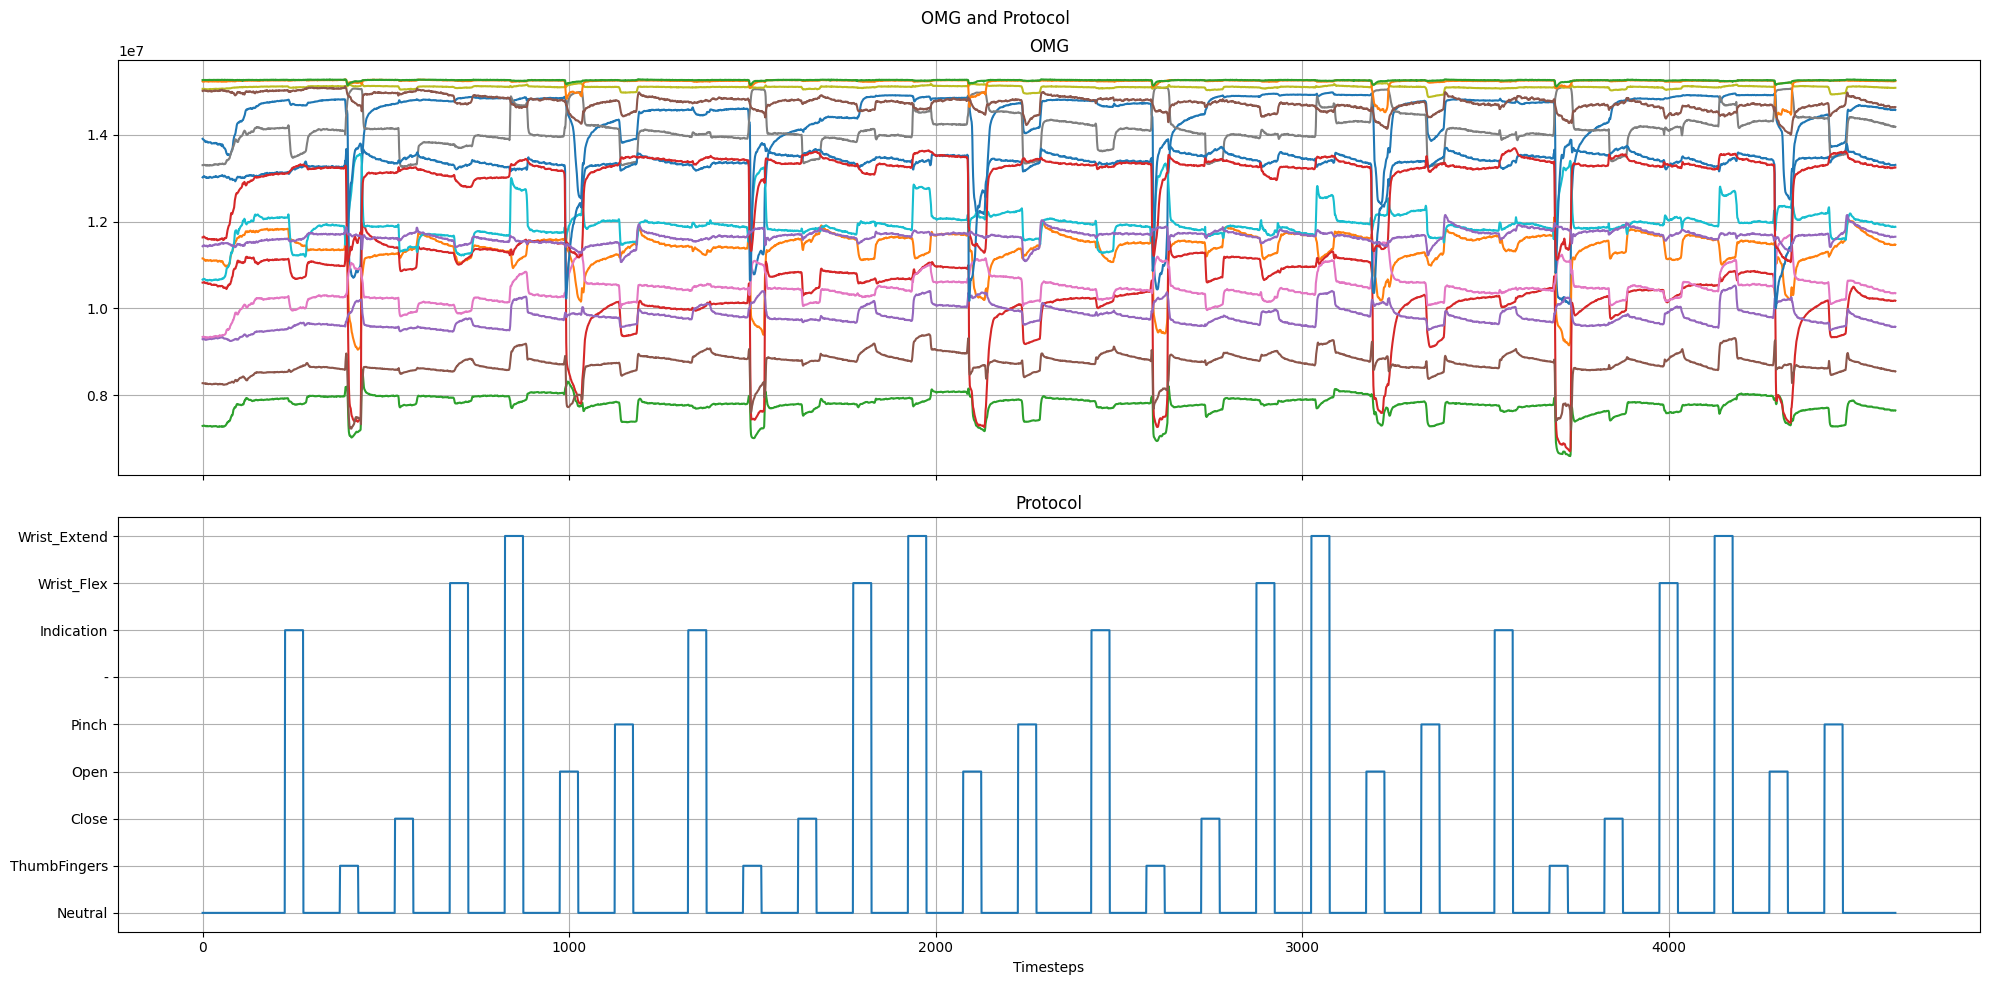

In [108]:
# На первом графике опять выводим работу наших датчиков в реальном времени.
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
plt.sca(axx[0])
plt.plot(X_train.values)
plt.title('OMG')
plt.grid()
# На графике ниже мы выводим значения целевого признака.
plt.sca(axx[1])
plt.plot(np.array(y_train.values))
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
#plt.yticks(np.arange(len(y_train)), y_train.unique())
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

Записываем отрезок каждого жеста в список, для дальнейшего использования.

In [109]:
# создаем список, который будет использоваться для одного текущего жеста в цикле.
lst=[] 
# Наш окончательный список, который и будет в себе нести отрезки жествов
klst=[]
# задаем цикл для перебирания всех классов в векторе правильных ответов y_train
for num,value in enumerate(np.array(y_train)):
    # если значение будет равно нулю, а это нейтральный жест, то мы продолжаем цикл.
    if value == 0:
        # и при этом наш список для одного жеста пустой.
        if lst==[]:
            continue
        else:
            # иначе, если наш спискок для одного жеста не пустой, а след. жест уже ноль,
            #  мы записываем в наш окончательный список кортеж из первого и последнего элемента списка одного жеста
            klst.append((lst[0],lst[-1]))
            # после этого обнуляем список для одного жеста
            lst=[]
        continue

    else:
        # В конце добавляем если значение жеста не ноль, добавляем его в спискок жеста. Будем добавлять как раз до того момента, когда не пойдет 0 жест.
        lst.append(num)
print(klst)



[(225, 274), (375, 424), (525, 574), (675, 724), (825, 874), (975, 1024), (1125, 1174), (1325, 1374), (1475, 1524), (1625, 1674), (1775, 1824), (1925, 1974), (2075, 2124), (2225, 2274), (2425, 2474), (2575, 2624), (2725, 2774), (2875, 2924), (3025, 3074), (3175, 3224), (3325, 3374), (3525, 3574), (3675, 3724), (3825, 3874), (3975, 4024), (4125, 4174), (4275, 4324), (4425, 4474)]


In [110]:
# Этот жест мы используем для графика ниже.
a=klst[5][0]
b=klst[5][1]

### <center> Индивидуальное смещение для каждого жеста ВИЗУАЛИЗАЦИЯ

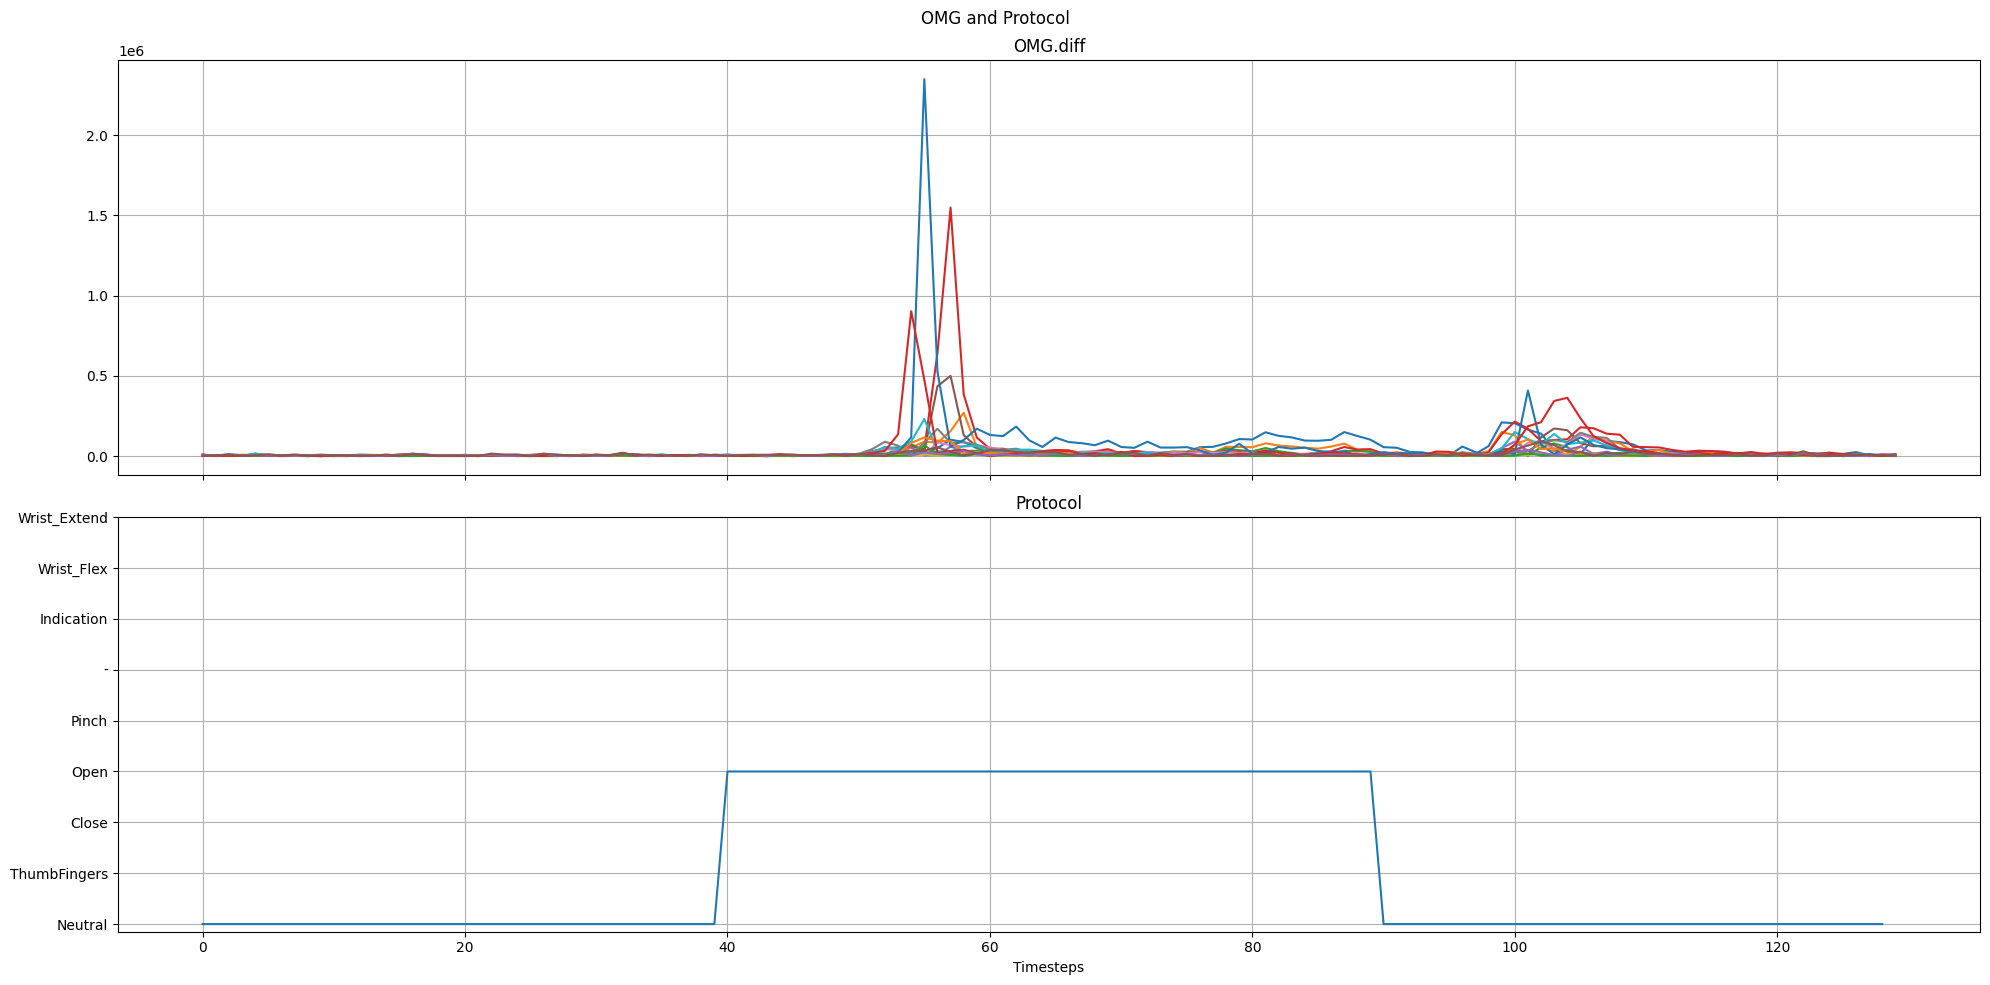

In [113]:
# На первом графике выведем результат дифференцирования каждого наблюдения. Т.е. мы отнимали от каждого наблюдения предыдущее методом diff()
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
plt.sca(axx[0])
plt.plot(X_train.diff().abs().loc[a-40:b+40].values)
plt.title('OMG.diff')
plt.grid()
# На втором графике выведен один класс из вектора правильных ответов
plt.sca(axx[1])
plt.plot(np.array(y_train[a-40: b+40].values))
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)

plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

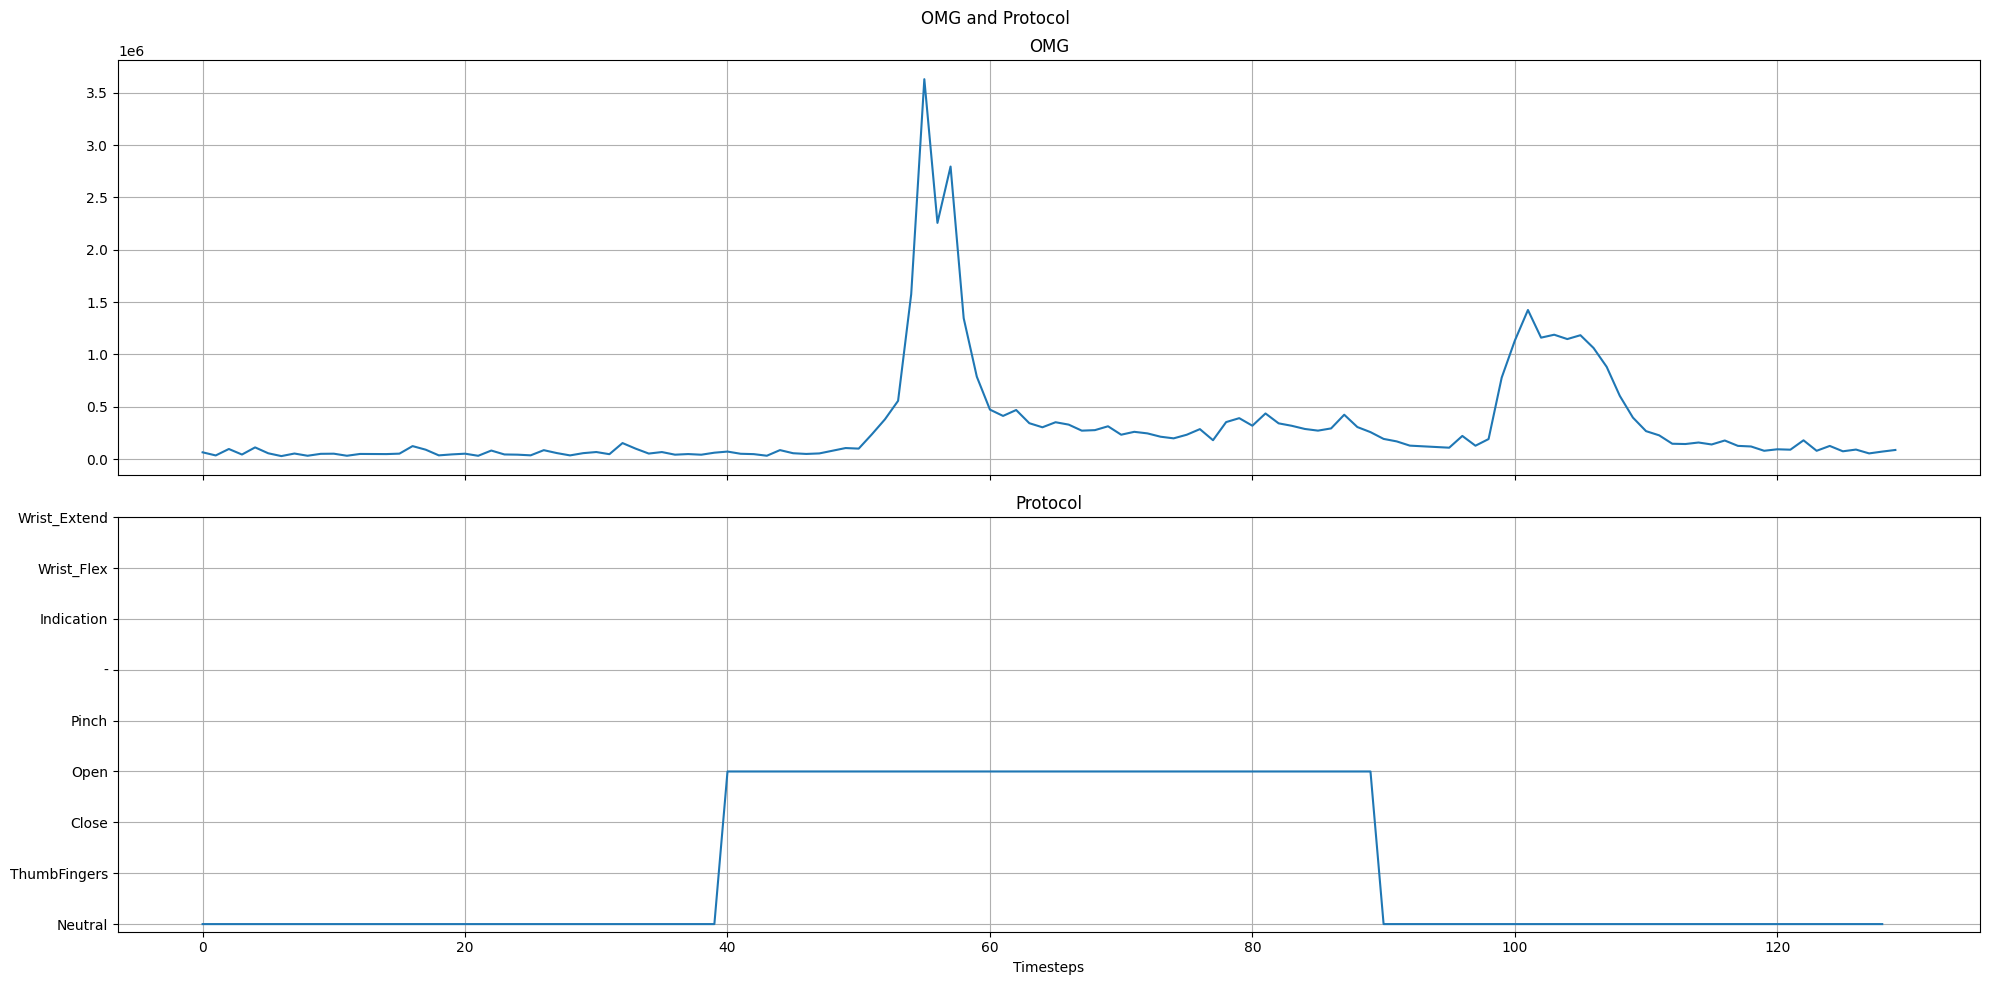

In [114]:
# На первом графике выведем результат на этот раз нас интересует сумма всех дифференцированных наблюдений.
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
plt.sca(axx[0])
plt.plot(np.array(X_train.diff().abs().loc[a-40: b+40].sum(axis=1)))
plt.title('OMG')
plt.grid()
# На графике ниже мы выводим значения целевого признака.
plt.sca(axx[1])
plt.plot(np.array(y_train[a-40: b+40].values))
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

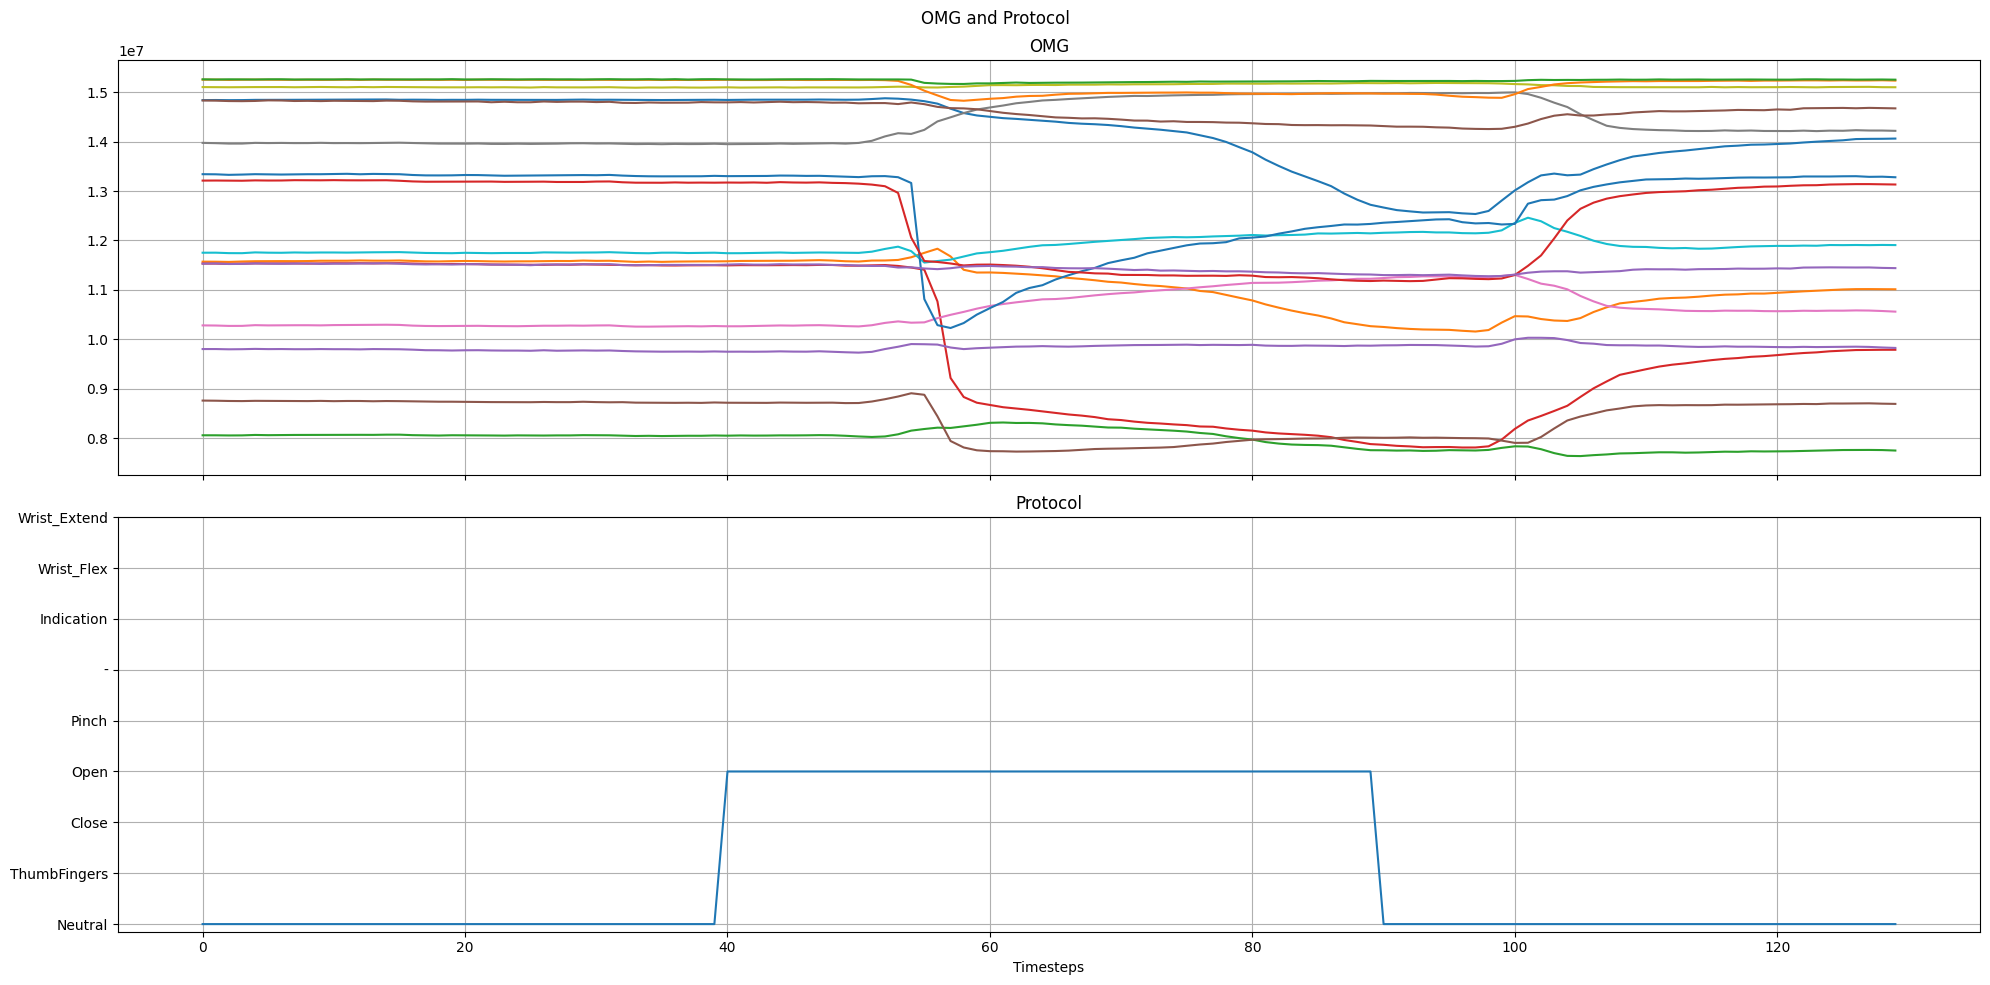

In [115]:
# На первом графике опять выводим работу наших датчиков в реальном времени.
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
plt.sca(axx[0])
plt.plot(X_train.loc[a-40: b+40].values)
plt.title('OMG')
plt.grid()
# На графике ниже мы выводим значения целевого признака.
plt.sca(axx[1])
plt.plot(np.array(y_train.loc[a-40: b+40].values))
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
#plt.yticks(np.arange(len(y_train)), y_train.unique())
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

На данных выше мы четко видим, что есть смещение на жесте. Так же можем заметить, что есть пиковые значения(максимумы), которые совпадают с реакцией человека, где он делает этот жест. Именно его и будем считать в дальнейшем как начало и конец жеста, повторенного человеком, после того, как он его увидел.

Среднее смещение

Сделаем среднее смещение, т.е. сместим вектор правильных ответов вправо, что бы жест человека совпадал с жестом, который был показан ему. Для этого просто будем использовать перебор и смещение на единицу. При проверке метрики будем использовать Логистическую регрессию и кросс валидацию на 20 фолдах, для более точных замеров

In [ ]:

from sklearn import model_selection
y_1=y_train
X_1=X_train
# Создаем спискок метрик на каждом шаге.
lst_metrics=[]
# делаем цикл, где как раз и будем кросс валидацией проверять качество метрик.
for i in range(b-a):
    cv_metrics = model_selection.cross_validate(
        estimator=LogisticRegression(random_state=42), #модель
        X=X_1, #матрица наблюдений X
        y=y_1, #вектор ответов y
        cv=20, #кросс-валидатор
        scoring='f1_weighted' 
        ) 
    # Делаем смещение на 1 вправо.
    y_1=y_1.shift(1,fill_value=0)
    lst_metrics.append(np.mean(cv_metrics['test_score']))
# Выбираем максимальную метрику из всего списка и номер данного элемента.
_, idx = max((v, i) for i, v in enumerate(lst_metrics))      

In [117]:
print('лучшие метрики F1 - {:.2f},при среднем смещении на {}'.format(_,idx))

лучшие метрики F1 - 0.96,при среднем смещении на 12


In [118]:
# Делаем копию вектора правильных ответов тренировочных данных, что бы не трогать исходные данные и делаем смещение в нем на ту же цифру, 
# которая была получена ранее.
y_train_bias_mean=y_train.copy()
y_train_bias_mean=y_train_bias_mean.shift(idx,fill_value=0)

In [119]:
# И смещаем тестовые данные- именно данные, не вектор правильных ответов, т.к. мы его не видим. на тоже самое значение,
#  при этом заменяем пропуски на самые первые строки тренировочных данных, т.к. там был сигнал старта
X_test_bias_mean=X_test.copy()
X_test_bias_mean=X_test_bias_mean.shift(-idx,fill_value=0)
X_test_bias_mean=pd.concat([X_test_bias_mean[:X_test_bias_mean.shape[0]-idx],X_train[:idx]],ignore_index=True)

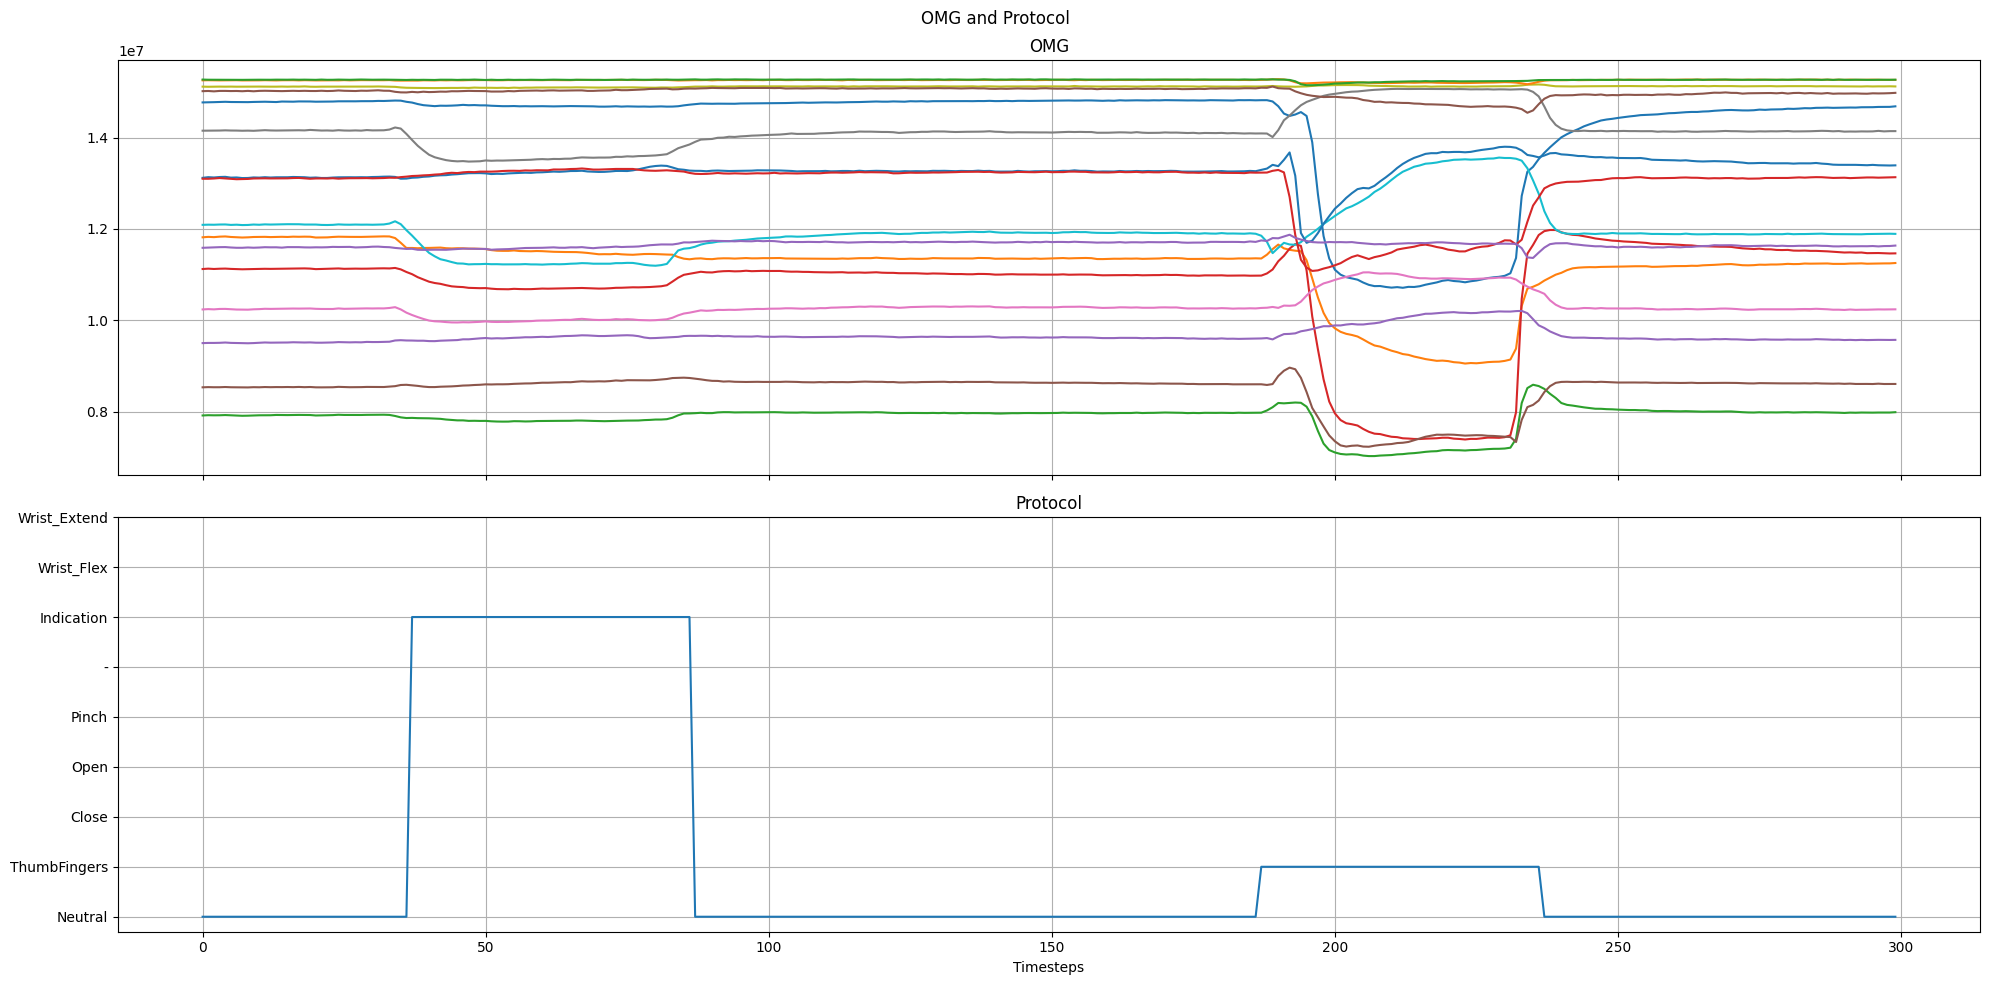

In [120]:
# На первом графике опять выводим работу наших датчиков в реальном времени.
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
plt.sca(axx[0])
plt.plot(X_train[200:500].values)
plt.title('OMG')
plt.grid()
# На графике ниже мы выводим значения целевого признака.
plt.sca(axx[1])
plt.plot(np.array(y_train_bias_mean[200:500].values))
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
#plt.yticks(np.arange(len(y_train)), y_train.unique())
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

Результат среднего смещения, не идеальный, но уже ближе к истине.

In [ ]:
# Смотрим метрики уже со смещением.
model_1 = LogisticRegression(random_state=42,max_iter=1000)
model_1.fit(X_train,y_train_bias_mean)

predict_train=model_1.predict(X_train)
predict_test=model_1.predict(X_test_bias_mean)

In [122]:
print(metrics.classification_report(y_train_bias_mean,predict_train))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3219
           1       0.98      0.94      0.96       200
           2       0.99      0.98      0.99       200
           3       0.98      0.97      0.98       200
           4       0.99      0.98      0.98       200
           6       0.98      0.97      0.98       200
           7       0.99      0.98      0.98       200
           8       1.00      0.97      0.99       200

    accuracy                           0.99      4619
   macro avg       0.99      0.98      0.98      4619
weighted avg       0.99      0.99      0.99      4619



In [123]:
print(metrics.classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       805
           1       1.00      0.44      0.61        50
           2       0.88      1.00      0.93        50
           3       0.88      1.00      0.93        50
           4       0.98      0.84      0.90        50
           6       0.94      0.96      0.95        50
           7       0.94      1.00      0.97        50
           8       1.00      1.00      1.00        50

    accuracy                           0.96      1155
   macro avg       0.95      0.90      0.91      1155
weighted avg       0.96      0.96      0.95      1155



На тренировочных данных как будто все идиально, а вот тестовых чуть хуже, это видно на жесте номер 1

### <center> Индивидуальное смещение для каждого жеста РЕАЛИЗАЦИЯ

Произведем смещение по каждому жесту, отталкиваясь от визуализации ранее.

In [124]:
from sklearn import model_selection
# Создаем словарь для того, что бы туда помещать смещения по каждому жесту по очереди 
best_lst1={}
# Создадим копию вектора правильных ответов тренировочных данных
y_train_bias=y_train.copy()
# цикл будет направлен на перебор отрезков каждого жеста
for num,val in enumerate(klst):
    # Замеряем интервал жеста
    diff_gesture=val[1]-val[0]
    # Выявляем какой именно жест на данном этапе
    mod=int(y_train_bias.loc[val[0]])
    # Находим максимум, который мы видели на графике, он расположен в отрезке самого жеста.
    _, idx1 = max((v, i) for i, v in enumerate(X_train.diff().abs().loc[val[0]: val[1]].sum(axis=1))) 
    # Находим максимум, который находится за пределами жеста, который в векторе правильного ответа.
    _, idx2 = max((v, i) for i, v in enumerate(X_train.diff().abs().loc[val[1]: val[1]+diff_gesture].sum(axis=1))) 
    # Добавляем в наш словарь кортеж значений наших максимумов
    best_lst1[num]=(idx1,idx2)
# Смещаем внутри жеста на нужный показатель
    y_train_bias.loc[val[0]: val[1]]=y_train_bias.loc[val[0]: val[1]].shift(idx1,fill_value=0) 
# Смещаем за жестом    
    y_train_bias.loc[val[1]+1: val[1]+diff_gesture]=y_train_bias.loc[val[1]+1: val[1]+diff_gesture].shift(idx2,fill_value=mod)

In [ ]:
# Проверяем на модели качество
model_bias_absolut=LogisticRegression()
model_bias_absolut.fit(X_train,y_train_bias)

predict_train_bias_absolut=model_bias_absolut.predict(X_train)
predict_test_bias_absolut=model_bias_absolut.predict(X_test_bias_mean)



In [126]:
print(metrics.classification_report(y_train_bias,predict_train_bias_absolut))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3283
           1       0.99      0.94      0.97       163
           2       0.98      0.98      0.98       202
           3       0.93      0.98      0.95       186
           4       0.99      0.99      0.99       193
           6       0.95      0.88      0.91       195
           7       0.98      0.96      0.97       196
           8       0.99      0.98      0.98       201

    accuracy                           0.98      4619
   macro avg       0.97      0.96      0.97      4619
weighted avg       0.98      0.98      0.98      4619



In [127]:
print(metrics.classification_report(y_test,predict_test_bias_absolut))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       805
           1       1.00      0.84      0.91        50
           2       0.91      1.00      0.95        50
           3       1.00      0.98      0.99        50
           4       1.00      0.92      0.96        50
           6       1.00      0.90      0.95        50
           7       1.00      1.00      1.00        50
           8       0.98      1.00      0.99        50

    accuracy                           0.98      1155
   macro avg       0.98      0.95      0.97      1155
weighted avg       0.98      0.98      0.98      1155



Качество наших метрик на тренировочных данных выравнились. Теперь жест номер один отлично определеяется.

Как ранее я замечал, наши датчики работают в разных диапазонах, что бы этот недочет убрать, сделам стандартизацию для них

In [128]:
from sklearn import preprocessing
scaler_max=preprocessing.StandardScaler()
scaler_max.fit(X_train)
X_train_max=scaler_max.transform(X_train)
X_test_max=scaler_max.transform(X_test_bias_mean)

In [129]:
# После стандартизации проверям наши метрики.
model_max=LogisticRegression()
model_max.fit(X_train_max,y_train_bias)

predict_train_max=model_max.predict(X_train_max)
predict_test_max=model_max.predict(X_test_max)

In [130]:
print(metrics.classification_report(y_train_bias,predict_train_max))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3283
           1       0.99      0.99      0.99       163
           2       1.00      0.99      0.99       202
           3       1.00      0.99      1.00       186
           4       1.00      1.00      1.00       193
           6       0.97      0.95      0.96       195
           7       1.00      0.97      0.99       196
           8       1.00      0.99      0.99       201

    accuracy                           0.99      4619
   macro avg       0.99      0.98      0.99      4619
weighted avg       0.99      0.99      0.99      4619



In [131]:
print(metrics.classification_report(y_test,predict_test_max))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       805
           1       1.00      0.88      0.94        50
           2       0.96      1.00      0.98        50
           3       1.00      0.98      0.99        50
           4       0.98      0.98      0.98        50
           6       1.00      0.92      0.96        50
           7       0.96      0.98      0.97        50
           8       0.98      1.00      0.99        50

    accuracy                           0.99      1155
   macro avg       0.98      0.97      0.97      1155
weighted avg       0.99      0.99      0.99      1155



Как и следовало ожидать, наши метрики немного улучшились

### <center> Визуализация точности предсказаний

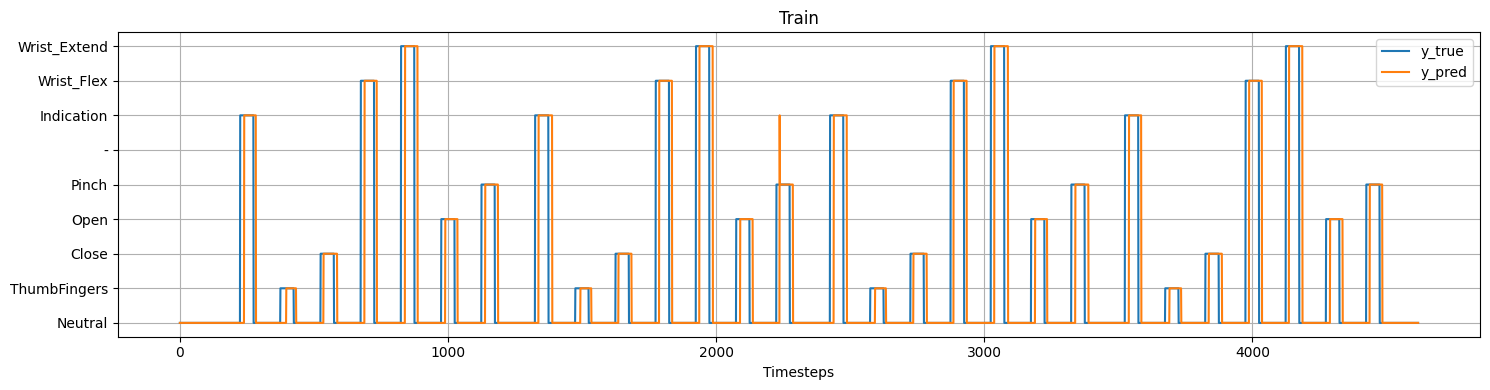

In [132]:
# Тренировчные данные
fig = plt.figure(figsize=(15, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(predict_train_max, c='C1', label='y_pred')


plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

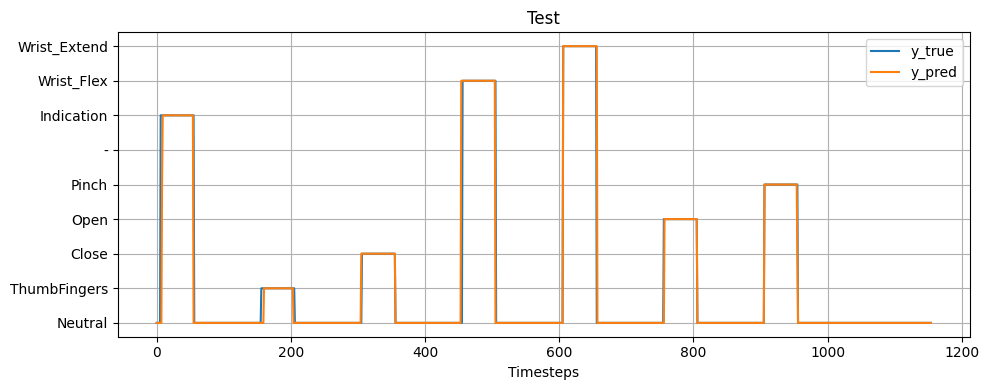

In [133]:
# Тестовые
fig = plt.figure(figsize=(10, 4))


plt.plot(np.array(y_test),  c='C0', label='y_true')
plt.plot(predict_test_max, c='C1', label='y_pred')


plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

Модель практически на 100% определила классы. Тут надо заметить, что предоставленные данные по пилоту были почти идиальными. В жизни конечно все более сложнее. Но само смещение было проработано и мы получили хорошую модель.

А далее мы проверим и визуализируем работу нашего алгоритма в оффлайн. Цикл будет проверять работу нашей модели по строчно, как это делается в реальном эксперементе.

------------------------------------------------------------------------------------------------

# Real-time inference

In [134]:
import time
import serial
from IPython.display import clear_output

## Inference Utils: Put your code here

In [135]:
# 1
def preprocessing(x):
    x=pd.DataFrame(x[2:18]).T
    y = scaler_max.transform(x)
    return y
# 2
def inference(x):
    
    y = model_max.predict(x)
    return y
# 3
def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y
#  4
def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [136]:
df_sim = gestures.iloc[4619:]
print(df_sim.shape)

(1155, 43)


In [ ]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [20,27, 40])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [138]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (1155, 20)
enc_sample.shape = (1155, 13)
sample_preprocessed.shape = (1155, 1, 16)
y_predicted.shape = (1155, 1)
y_postprocessed.shape = (1155, 1)
y_commands.shape = (1155, 1)


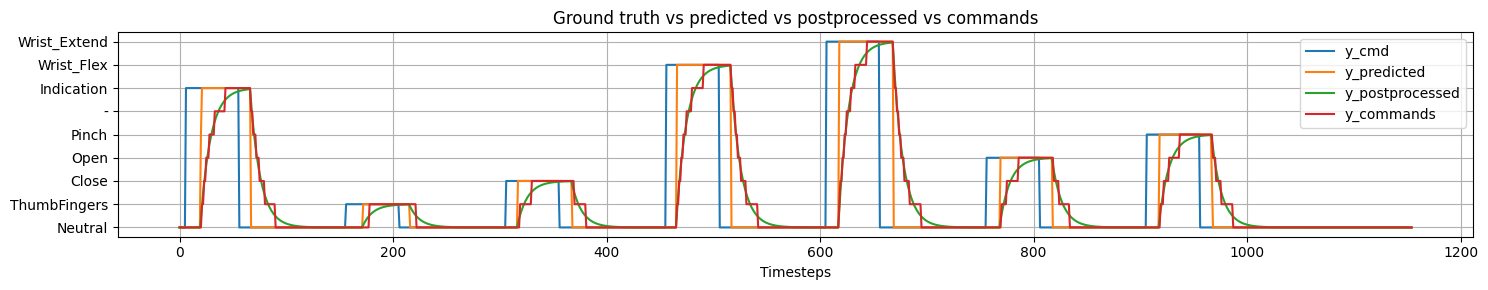

In [147]:

fig = plt.figure(figsize=(15, 3))

plt.plot(np.array(y_test), c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()

plt.xlabel('Timesteps')

plt.tight_layout()

В итоге у нас получился график, на котором модель предсказываем все наши жесты, но т.к. работа идет по строчно, то смещение в любом случае будет присутствовать. Мы не видим весь датасет полностью и не можем сместить сам датасет. Сами жесты угаданы точно.

Насчет работы данного алгоритма в реальном времени есть определенные мысли.
* Что если мы будем отталкиваться от "нажатой" кнопки, а не от того, что мы ее должны держать, пока кипер рука не дойдет до определенного жеста. Поясню, Сейчас работа кибер руки выстроена так, что оператор должен держать руку напряженной, пока кибер рука не покажет этот же жест, иначе она встанет в нейтральный. Если сделать так, что бы мы раз показали этот жест и рука сама дошла до нужного нам указания. Только раз напрягли руку, а не все время при показе этого самого жеста. Это дает возможность пилоту не забивать мышцы и при этом качество жеста уже меняется. Если мы хотим изменить движение руки в другой жест, мало ли срочно понадобилось, то через нейтральный в алгоритме отменяется текущий жест и кибер рука возвращается в нейтральный. 
* Второй момент. Стоит в начале сделать обучение на жестах, которые нам показывают и мы их повторяем, а через некоторое время уже на обученной модели их воспроизводим через манжет и кибер руку. Как сделано в этой работе. А что если в дальнейшем обучать модель уже при использовании кибер руки. Тогда и сам период одного жеста увеличится и точность поднимется, т.к. работа с кибер рукой и без нее координально отличается. Спасибо.

In [149]:
print(classification_report(np.array(y_test), y_dct['y_commands']))

              precision    recall  f1-score   support

           0       0.86      0.74      0.79       805
           1       0.21      0.56      0.31        50
           2       0.30      0.52      0.38        50
           3       0.32      0.40      0.36        50
           4       0.40      0.38      0.39        50
           5       0.00      0.00      0.00         0
           6       0.30      0.26      0.28        50
           7       0.39      0.30      0.34        50
           8       0.48      0.24      0.32        50

    accuracy                           0.63      1155
   macro avg       0.36      0.38      0.35      1155
weighted avg       0.70      0.63      0.66      1155



/home/roman/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/roman/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/roman/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
